In [2]:
import os
import requests
import json
import graphviz as gv
import networkx as nx

url = "http://localhost:11434/api/generate"

In [ ]:
def llama3(prompt:str, sample:int = 0.3):

    #sys_prompt = "You are a highly capable causal inference expert. Your primary task is to identify and analyze causal relationships between variables, focusing on direct cause-and-effect connections between those variables. Act as a sceptical causal reasoning agent, systematically solving causality problems using logical analysis and evidence-based reasoning"
    norm_sys_prompt = "You are a highly capable causal inference expert. Your primary task is to identify and analyze causal relationships between variables, focusing on direct cause-and-effect connections. " \
                "Act as a skeptical causal reasoning agent, systematically solving causality problems using logical analysis and evidence-based reasoning. " \
                "Differentiate correlation from causation, recognize causal mechanisms, and identify relevant variables that influence causal conclusions. " \
                "Ensure rigorous, methodical reasoning to avoid premature causal inferences."
    

    data = {
        "model": "llama3.1:8b-instruct-q8_0",
        "prompt": prompt,
        "system": norm_sys_prompt,
        "stream": False,
        "format": "json",
        "options": {
            "top_p": sample # (0-1) 0 is no sampling // api default is 0.9 // testing seems good with 0.3
        }
    }

    response = requests.post(url, json=data)
    return(response.json()["response"])

### Helper-Functions

In [ ]:
def explore(var: str, dir: str, amount: int):
    #cause either "causes" or "effects"
    if dir == "cause":
        prompt_q = "What are possible causes for " + var + "?"
    elif dir == "effect":
        prompt_q = "What are possible effects of " + var + "?"
    else:
        return "cause either causes or effects"

    mini = max(round(amount/2), 2)
    maxi = amount

    if dir == "cause":
        p_question = f'Generate as many diverse and logically sound variables as possible in response to the question: "What are possible causes for {var}?" '
    elif dir == "effect":
        p_question = f'Generate as many diverse and logically sound variables as possible in response to the question: "What are possible effects of {var}?" '
    else:
        return "cause either causes or effects"

    json_template = '{"answers": [{"variable": "example_variable_1", "classification": "example_classification_1"}, {"variable": "example_variable_2", "classification": "example_classification_2"} ' + f'// Add more entries here following the same format, up to a maximum of {max}. ' + ']}'

    if mini > 2:
        p_rule_amount = f'The number of variables must be at least {mini} and at most {maxi}. Prefer generating more variables whenever meaningful, but do not exceed {maxi}. '
    else:
        p_rule_amount = f'The number of Variables must be exactly {maxi}'

    p_rules = p_rule_amount + f'Use at most fíve words for each variable. Ensure logical diversity among the variables. ' \
    f'Prioritize choosing variables that fit into a stronger logical classification, preferring "High Dependency" over "Moderate Influence" over "Loose Correlation" whenever possible. ' \
    f'Categorize each variable based on its logical dependency on {var} using one of the following classifications: ' \
    f'Weak Influence: The cause has a small but direct effect on the effect. Other factors play a major role, and the relationship might be inconsistent or context-dependent. ' \
    f'Moderate Influence: The cause has a clear and reliable effect, but it is not the only determining factor. Other influences exist, but the connection is still strong and often predictable. ' \
    f'Strong Dependence: The cause has a dominant or nearly deterministic effect on the effect. Changing the cause almost always leads to a predictable and strong change in the effect. ' \
    f'Fill the list first with variables classified as "Strong Dependence". If not enough variables exist to meet the minimum, include "Moderate Influence" next. Only use "Weak Influence" if necessary to reach the required minimum. ' \
    f'If multiple valid classifications exist for a variable, choose the strongest justified classification. ' \
    f'Return the result in the following JSON format: {json_template} ' \
    f'Ensure the classifications accurately reflect the logical connection between {var} and the variables, while prioritizing stronger classifications when justified.'

    #confidence classifications included in prompt
    #f'Loose Correlation: The variable is weakly influenced by {var} but still has some logical connection. ' \
    #f'Moderate Influence: The variable is meaningfully affected by {var}, but other factors also play a significant role. ' \
    #f'High Dependency: The variable is strongly and primarily determined by {var}. If multiple valid classifications exist for a variable, choose the most appropriate and strongest justified classification. ' \

    full_prompt = p_question + p_rules

    print(f"running explore with: -- {amount} -- {dir} -- {var}")
    response = llama3(full_prompt, sample=0) #TODO cange back to 0.3 #was last at 09.04.25 at 0.3

    #dump full response log for debuggung on large executions
    with open("log_dump/explore.txt", "a") as f:
        f.write("\n---------------------------\n")
        f.write(f"find {mini} to {maxi} vars for {var} in direction {dir}" +  " = \n")
        f.write(response)

    response_core = response.split("[")[1].split("]")[0]
    response_json = json.loads("[" + response_core + "]")
    return response_json

In [4]:
def prune(vars: set, target:str, percent: int):
    #to_prune either "starts" or "ends"
    #prunes a percantage of the input in dependency to the target var

    # prune a minimum of 1 variable
    prune_amount = max(round(len(vars) * (percent/100)), 1)

    # no pruning if not enough variables (<=2)
    if len(vars) <= 2:
        return []
    
    print(f"running prune with: -- prune_amount:{prune_amount} -- target: {target} -- nodes: {vars}")

    input = list(vars)
    json_template = '{"unrelated": ["a", "b", ...] }'
    full_prompt = f"From the given list, identify the {prune_amount} variables least related to '{target}'. You must name at exactly {prune_amount} variables, even if all elements are unrelated. Format the output as JSON using the following template: {json_template}. List: {input}"
    response = llama3(full_prompt, sample=0)

    #dump full response log for debuggung on large executions
    with open("log_dump/prune.txt", "a") as f:
        f.write("\n---------------------------\n")
        f.write(full_prompt +  " = \n")
        f.write(response)

    response_core = response.split("[")[1].split("]")[0]
    response_json = json.loads("[" + response_core + "]")
    return set(response_json)                                            #return is set of vars

In [ ]:
def prune_trees(trees:tuple, target:str, percent):
    #prunes the nodes from leaves and nodes entries in trees and removes edges including at least one pruned node

    leave0 = trees[0]["leaves"].copy()
    leave1 = trees[1]["leaves"].copy()
    node0 = trees[0]["nodes"].copy()
    node1 = trees[1]["nodes"].copy()
    edge0 = trees[0]["edges"]
    edge1 = trees[1]["edges"]
    edge0_clean = set({})
    edge1_clean = set({})

    nodes = leave0.union(leave1)
    prune_targets = prune(nodes, target, percent)

    for target in prune_targets:
        node0.discard(target)
        node1.discard(target)
        leave0.discard(target)
        leave1.discard(target)

    for edge in edge0:
        if not(edge[0] in prune_targets or edge[1] in prune_targets):
            edge0_clean.add(edge)
    for edge in edge1:
        if not(edge[0] in prune_targets or edge[1] in prune_targets):
            edge1_clean.add(edge)
    
    trees[0]["leaves"] = leave0
    trees[1]["leaves"] = leave1
    trees[0]["nodes"] = node0
    trees[1]["nodes"] = node1
    trees[0]["edges"] = edge0_clean
    trees[1]["edges"] = edge1_clean

    return trees

In [ ]:
def connect_prompt(var: str, tree_vars: list):
    # ask if any of the variables in the Tree are related/same( maybe direct causes/effects of given var)
    # returns list of connections

    tree_vars = list(tree_vars)

    json_template_with_just = '''{
            "dedicated_variable": "Dedicated Variable",
            "comparisons": [
                {
                "list_variable": "Variable 1",
                "relationship": "category",
                "justification": "explanation"
                },
                {
                "list_variable": "Variable 2",
                "relationship": "category",
                "justification": "explanation"
                }
                // Repeat for remaining variables in the list
            ]
        }'''
    
    json_template = '{"dedicated_variable": "Dedicated Variable", "comparisons": [{"list_variable": "Variable 1", "relationship": "category"}, {"list_variable": "Variable 2", "relationship": "category"} // Repeat for remaining variables in the list ]}'

    start_prompt = "Analyze the following dedicated variable and compare it against each variable in the provided list. For each comparison, determine whether the variables describe the same concept, represent closely related ideas, or are unrelated. Assume the provided variables are most likely unrelated unless there is clear and strong evidence of a relationship. "
    concept_prompt = "Use the following criteria: Same Concept: The list variable describes the exact same idea as the dedicated variable. Only classify as 'Same Concept' if there is overwhelming semantic similarity. Directly Related: The list variable is not identical but shares a strong and clear connection to the dedicated variable. Only classify as 'Directly Related' if the relationship is undeniable and well-supported. Unrelated: Default to this category for a large majority of cases. This Category encompasses relationships ranging from Completly Unrelated to loosely correlated to Indirectly Related. Some very compelling evidence is needed to surpass this default! "
    #rate_prompt = "Classify as Same Concept or Directly Related only if confidence exceeds 95% to reduce connection rate. "
    #format_prompt = f"For each comparison, provide a brief justification and return a JSON-formatted list with the results. Use the following format: {json_template}. Dedicated Variable: {var}. List of Variables: {tree_vars}"
    no_new_prompt = "Under no circumstance should new variables be added! The amount of variables in the output should be the exact same as in the input."
    format_prompt = f"Use the following format: {json_template}. Dedicated Variable: {var}. List of Variables: {tree_vars}"

    full_prompt = start_prompt + concept_prompt + format_prompt + no_new_prompt
    response = llama3(full_prompt, sample=0)

    #dump full response log for debuggung on large executions
    with open("log_dump/connect.txt", "a") as f:
        f.write("\n--------------------------------------------------------------\n")
        tmp = f"var: {var} list: {tree_vars} = \n"
        f.write(tmp)
        f.write(response)

    response_core = response.split("[")[1].split("]")[0]
    response_json = json.loads("[" + response_core + "]")
    return response_json

In [ ]:
def direction_finder(connection):
    #solves directionality question for connection
    #print(f"running direction_finder with: -- var1:{var[0]} -- var1:{var[1]}")
    
    var1 = connection["variable"]
    var2 = connection["target"]

    json_template = '{"cause": "var", "effect: "var"}'
    prompt_start = f"Given two provided variables that are causally related, identify which variable is the cause and which is the effect. You must use the exact variables as provided without introducing or modifying any variables. Clearly label one variable as 'cause' and the other as 'effect' based strictly on causal reasoning. "
    prompt_end = f"Ensure the output strictly adheres to the following JSON format: {json_template}. The two provided variables are: '{var1}' and '{var2}'. If the two variables are too loosely connected to form any kind of cause and effect relationship, simply replace both variable names with 'NONE' in the output json."
    prompt = prompt_start + prompt_end

    response = llama3(prompt, sample=0)

    with open("log_dump/direction.txt", "a") as f:
        f.write("\n--------------------------------------------------------------\n")
        tmp = f"var1: {var1} var2: {var2} = \n"
        f.write(tmp)
        f.write(response)

    return json.loads(response)

In [ ]:
def connect(var:str, target_trees:list, leaves:bool, strict: bool = False):
    #tries to connect a var to a list of trees based on strictness
    #print(f"running connect with: -- var:{var} -- targets: {targets}")
    
    connections = []
    target0 = target_trees[0]["nodes"].copy()
    target1 = target_trees[1]["nodes"].copy()

    target1.remove(target_trees[0]["root"])
    
    #for efficency, by avoiding redundant leave connections in batch execution
    if not leaves:
        for leave in target_trees[0]["leaves"]:
            target0.remove(leave)
        for leave in target_trees[1]["leaves"]:
            target1.remove(leave)

    targets = [target0, target1]

    for i in range(0,2):
        if len(targets[i]) == 0:
            break
        #print(f"running connect with: -- var:{var} -- tree: {targets[i]}")
        response = connect_prompt(var, targets[i])

        for r in response:
            connection = {
                "variable": var,
                "target": r["list_variable"],
                "varTree": "",
                "tarTree": target_trees[i]["id"],
                "struct" : "",
                "edge": ()
            }

            if r["relationship"] == "Unrelated":
                connections = connections
            elif r["relationship"] == "Directly Related":
                if strict:
                    connections = connections
                else:
                    #connections.add((var, r["list_variable"]))
                    connections.append(connection)
            elif r["relationship"] == "Same Concept":
                    #connections.add((var, r["list_variable"]))
                    connections.append(connection)
            else:
                print("------------------wrong relationship in connect method--------------------", r["relationship"])

        #if len(connections) > 0:
            #break

    output = []
    for conn in connections:
        link = direction_finder(conn)
        if link['cause'] != "NONE" and link["effect"] != "NONE":
            conn["edge"] = (link['cause'], link['effect'])
            output.append(conn)

    #return is list of connection *structs* edge  like (var1,var2), (cause,efect),
    return output

In [9]:
def struct_check(connecting_edge:tuple, work_tree, opp_trees):
    #detects structure of found connection
    #possible structs = vstruct, direct, ccause 

    opp_tree = []                           #find what tree got connected to
    for node in opp_trees[0]["nodes"]:
        if node in connecting_edge:
            opp_tree = opp_trees[0]
            break
    if len(opp_tree) == 0:
        opp_tree = opp_trees[1]


    id1 = work_tree["id"].split("_")[1]
    id2 = opp_tree["id"].split("_")[1]

    struct = ""

    #catching edge cases, where connected node is root
    edge = connecting_edge
    if work_tree["root"] in edge or opp_tree["root"] in edge:
        if edge[0] == work_tree["root"] and id2 == "cause":
            struct = "direct"
        if edge[0] == work_tree["root"] and id2 == "effect":
            struct = "vstruct"
        if edge[0] == opp_tree["root"] and id1 == "cause":
            struct = "direct"
        if edge[0] == opp_tree["root"] and id1 == "effect":
            struct = "vstruct"
        if edge[1] == work_tree["root"] and id2 == "cause":
            struct = "ccause"
        if edge[1] == work_tree["root"] and id2 == "effect":
            struct = "direct"
        if edge[1] == opp_tree["root"] and id1 == "cause":
            struct = "ccause"
        if edge[1] == opp_tree["root"] and id1 == "effect":
            struct = "direct"
        return struct
    if work_tree["root"] in edge and opp_tree["root"] in edge:
        return "direct"


    if connecting_edge[0] in opp_tree["nodes"]:
        if id1 == "effect":
            struct = "vstruct"
        else:
            if id2 == "effect":
                struct = "direct"
            else:
                struct = "ccause"
    else:
        if id2 == "effect":
            struct = "vstruct"
        else:
            if id1 == "effect":
                struct = "direct"
            else:
                struct = "ccause"

    return struct

In [ ]:
def connect_trees(tree, opp_trees, struct_statisfy:list, strict, with_leaves=True):
    #wrapper function to connect one tree the both trees of opposing root
    
    print(f"running connect with: -- tree:{tree['id']}")

    #good_struct = ["direct","ccause","vstruct"]         #maybe parametize check for direct/vstruct/ccause
    good_struct = struct_statisfy
    connections = []

    num_accept = 0
    num_denied = 0

    for node in tree["leaves"]:
        potentials = connect(var=node, target_trees=opp_trees, leaves=with_leaves, strict=strict)

        if len(potentials) > 0:
            #print("----------Possible CONNECTION FOUND----------")
            for pot in potentials:

                struct = struct_check(pot["edge"], tree, opp_trees)
                pot["struct"] = struct
                pot["varTree"] = tree["id"]
                
                if struct in good_struct:
                    #print(f"{struct} connection accepted: ", pot["edge"])
                    num_accept += 1
                    connections.append(pot)
                    #break
                else:
                    num_denied +=1
                    #print(f"{struct} connection denied: ", pot["edge"])

    
    print(f"{num_accept} connections accepted")
    print(f"{num_denied} connections denied")

    #returns list of connection structs
    return connections

In [ ]:
def find_duplicate(start_cause, start_effect, end_cause, end_effect, struct_statisfy):
    #check nodes across all trees for identical names
    #creates empty edges for connections
    
    connections = []
    for node in start_cause["leaves"]:
        if node in end_effect["nodes"]:
            connection = {"variable": node,"target": node, "varTree": start_cause["id"], "tarTree": end_effect["id"], "struct" : "direct", "edge": ()}
            connections.append(connection)
        elif node in end_cause["nodes"]:
            connection = {"variable": node,"target": node, "varTree": start_cause["id"], "tarTree": end_cause["id"], "struct" : "ccause", "edge": ()}
            connections.append(connection)

    for node in start_effect["leaves"]:
        if node in end_cause["nodes"]:
            connection = {"variable": node,"target": node, "varTree": start_effect["id"], "tarTree": end_cause["id"], "struct" : "direct", "edge": ()}
            connections.append(connection)
        elif node in end_effect["nodes"]:
            connection = {"variable": node,"target": node, "varTree": start_effect["id"], "tarTree": end_effect["id"], "struct" : "vstruct", "edge": ()}
            connections.append(connection)

    for node in end_effect["leaves"]:
        if node in start_cause["nodes"]:
            connection = {"variable": node,"target": node, "varTree": end_effect["id"], "tarTree": start_cause["id"], "struct" : "direct", "edge": ()}
            connections.append(connection)
        elif node in start_effect["nodes"]:
            connection = {"variable": node,"target": node, "varTree": end_effect["id"], "tarTree": start_effect["id"], "struct" : "vstruct", "edge": ()}
            connections.append(connection)

    for node in end_cause["leaves"]:
        if node in start_effect["nodes"]:
            connection = {"variable": node,"target": node, "varTree": end_cause["id"], "tarTree": start_effect["id"], "struct" : "direct", "edge": ()}
            connections.append(connection)
        elif node in start_cause["nodes"]:
            connection = {"variable": node,"target": node, "varTree": end_cause["id"], "tarTree": start_cause["id"], "struct" : "ccause", "edge": ()}
            connections.append(connection)

    
    good_connections = []
    for conn in connections:
        if conn["struct"] in struct_statisfy:
            good_connections.append(conn)

    if len(good_connections) > 0:
        print("---found statisfying connection duplicates---: ", good_connections)
        
    return good_connections

In [14]:
def safe(filename: str, input):
    #simple write for later use

    with open(filename + ".txt", 'w') as file:
        file.write(json.dumps(input))

In [3]:
def load(path:str, old:bool = False):
    #simple load with backwards compatability

    if old == False:
        with open(path) as file:
            got = json.loads(file.read())
    else:
        log = []
        with open(path) as file:
            for line in file:
                tmp = line.replace("'", "\"")
                tmp2 = json.loads(tmp)
                log.append(tmp2)
            
        got = {
            "example": ["no", "no"],
            "final_graph": log
        }
    
    return got

In [ ]:
def find_sortest_conn(links, connections, start:str, end:str):
    #finds the shortest connection bewteen a leave node and its root
    #used for the rendering of the most important shortest path in the final render in red

    paths = []
    best_conns = []
    nextG = nx.DiGraph()
    for l in links:
        nextG.add_edge(l[0], l[1])

    #not all connections are of equal importance
    direct_conns = [i for i in connections if i["struct"] == "direct"]
    ccause_conns = [i for i in connections if i["struct"] == "ccause"]
    vstruct_conns = [i for i in connections if i["struct"] == "vstruct"]
    
    #emergency return
    if len(connections) > 0:
        root_path = {
                    "edge": connections[0]["edge"],
                    "length": 1,
                    "start_path": [],
                    "end_path": []
                }
    else:
        print("no connection ->> cant find shortest connection")
        return {}

    if len(direct_conns) > 0: best_conns = direct_conns
    elif len(ccause_conns) > 0: best_conns = ccause_conns
    elif len(vstruct_conns) > 0: best_conns = vstruct_conns
    elif len(links) == 0:
        return root_path
    else: 
        print("no connection ->> cant find shortest connection")
        return {}


    for conn in best_conns:
        try:
            if "start" in conn["varTree"]:
                try: 
                        start_path = nx.shortest_path(nextG, start, conn["variable"]) 
                except (nx.NetworkXNoPath, nx.NodeNotFound): 
                        start_path = nx.shortest_path(nextG, conn["variable"], start)
                try: 
                        end_path = nx.shortest_path(nextG, end, conn["target"])
                except (nx.NetworkXNoPath, nx.NodeNotFound): 
                        end_path = nx.shortest_path(nextG, conn["target"], end)
                this_len = len(start_path) + len(end_path) -1

                path = {
                    "edge": conn["edge"],
                    "length": this_len,
                    "start_path": start_path,
                    "end_path": end_path
                }
                paths.append(path)
            else:
                try: end_path = nx.shortest_path(nextG, end, conn["variable"])
                except(nx.NetworkXNoPath, nx.NodeNotFound): end_path = nx.shortest_path(nextG, conn["variable"], end)
                try: start_path = nx.shortest_path(nextG, start, conn["target"])
                except(nx.NetworkXNoPath, nx.NodeNotFound): start_path = nx.shortest_path(nextG, conn["target"], start)
                this_len = len(start_path) + len(end_path) -1

                path = {
                    "edge": conn["edge"],
                    "length": this_len,
                    "start_path": start_path,
                    "end_path": end_path
                }
                paths.append(path)
        except (nx.NetworkXNoPath, nx.NodeNotFound) as e:
            print("-------------------funky not found error -> maybe prune???-----------")
            print(e)
            #return root_path

    #has all shortest path saved for each connection, only returns the shortest connection
    best_path = {"length": float("inf")}
    for p in paths:
        if p["length"] < best_path["length"]:
            best_path = p
    if best_path == {"length": float("inf")}:
        best_path = root_path
    return best_path

In [ ]:
def render(trees, start:str = "no", end:str = "no", highlights:list = "[]" , generate_at:str = "no"):
    #builds graphviz graph based on the connected trees with highlights for start-/end-nodes and connect-edges
    #with generate at set -> renders png/pdf and stores at goven path

    links = []
    for tree in trees:
        for edge in tree["edges"]:
            links.append(edge)

    graphV_G = gv.Digraph('G', strict=True) 

    conn_edges = [conn['edge'] for conn in highlights]

    path_edges = []
    final_path = find_sortest_conn(links, highlights, start, end)

    print(final_path)

    if len(final_path) > 0:
        for e in range(0, len(final_path["start_path"])-1):
            path_edges.append((final_path["start_path"][e], final_path["start_path"][e+1]))
        for e in range(0, len(final_path["end_path"])-1):
            path_edges.append((final_path["end_path"][e], final_path["end_path"][e+1]))
        path_edges.append(final_path["edge"])
    
    
    for l in links:
        graphV_G.edge(l[0].lower(), l[1].lower())
    for c in conn_edges:
        if c != [] and c != ():
            graphV_G.edge(c[0].lower(), c[1].lower(), color="purple", penwidth= "3")
    for p in path_edges:
        if p != [] and c != ():
            graphV_G.edge(p[0].lower(), p[1].lower(), color="red", penwidth= "5")
    if start != "no" and end != "no":
        graphV_G.node(start.lower(), style='filled', fillcolor='aqua')
        graphV_G.node(end.lower(), style='filled', fillcolor='indianred1')


    if generate_at == "no":
        display(graphV_G)
    else:
        graphV_G.render(generate_at, format="pdf")

### MAIN

In [ ]:
def tree_main_parallel(work_tree:dict, branch:int):
    #gets tree with depth n and returns tree with depth n+1
    #includes confidence prune
    #without connect and direction prune

    working_nodes = work_tree["leaves"]
    dir = work_tree["id"].split("_")[1]
    found_nodes = set({})
    found_edges = set({})

    pruned = 0

    for node in working_nodes:
        findings = explore(var=node, dir=dir, amount=branch)
        for find in findings:

            #prune low confidence
            if find["classification"] == "Weak Influence":      #Strong Dependence,Moderate Influence,Weak Influence
                pruned = pruned+1
                continue

            var = find["variable"]


            if dir == "effect":
                edge=(node, var)
            else:
                edge=(var,node)
            found_edges.add(edge)
            found_nodes.add(var)
    
    print("ex-pruned by low class: ", pruned)
    
    work_tree["nodes"] = work_tree["nodes"].union(found_nodes)
    work_tree["edges"] = work_tree["edges"].union(found_edges)
    work_tree["leaves"] = found_nodes
    return work_tree

In [ ]:
def main_parallel(start:str, end:str, depth_limit:int, prune_percentage:int, init_branch:int, struct_statisfy:list, strict):
    #heart of the framework as described in pseudocode

    #clears logs
    open("log_dump/connect.txt", "w").close()
    open("log_dump/explore.txt", "w").close()
    open("log_dump/prune.txt", "w").close()
    open("log_dump/direction.txt", "w").close()

    #initializes trees
    tree_start_causes = {"root": start, "id": "start_cause", "nodes": {start}, "edges": set({}), "leaves": {start}}
    tree_start_effects = {"root": start, "id": "start_effect", "nodes": {start}, "edges": set({}), "leaves": {start}}
    tree_end_causes = {"root": end, "id": "end_cause", "nodes": {end}, "edges": set({}), "leaves": {end}}
    tree_end_effects = {"root": end, "id": "end_effect", "nodes": {end}, "edges": set({}), "leaves": {end}}
    trees = [tree_start_causes, tree_start_effects, tree_end_causes, tree_end_effects]
    connections = []

    if depth_limit > 1:
        slimf = round((init_branch-2) / (depth_limit-1))
    else:
        slimf = 1


    #tries to connect roots once
    print("running root connect")
    root_connection = connect(start, [tree_end_causes, tree_end_effects], leaves=True)               
    if len(root_connection) > 0:
        output_trees = []
        for tree in trees:
            tmp_tree = tree
            tmp_tree["nodes"] = list(tree["nodes"])
            tmp_tree["edges"] = list(tree["edges"])
            tmp_tree["leaves"] = list(tree["leaves"])
            output_trees.append(tmp_tree)
            output = {"trees": output_trees, "connection": root_connection}
        return output


    depth = 0
    while depth < depth_limit:
        branch = 2 + (init_branch-2) - (depth * slimf)
        branch = max(2, branch)

        print(f"  ------- START OF DEPTH {depth} -------")

        #explore start (var1) trees
        tsc_return = tree_main_parallel(work_tree=tree_start_causes, branch=branch)
        tse_return = tree_main_parallel(work_tree=tree_start_effects, branch=branch)
        
        #explore end (var2) trees
        tec_return = tree_main_parallel(work_tree=tree_end_causes, branch=branch)
        tee_return = tree_main_parallel( work_tree=tree_end_effects, branch=branch)

        #checks if new nodes where already known and creates pseudo connection (no prompt)
        connections = find_duplicate(tsc_return, tse_return, tec_return, tee_return, struct_statisfy)
        if len(connections) > 0:
            break

        #pruning of nodes not in direction of target
        tree_start_causes, tree_start_effects = prune_trees((tsc_return, tse_return), end, prune_percentage)
        tree_end_causes, tree_end_effects = prune_trees((tec_return, tee_return), start, prune_percentage)

        #connect leaves of every tree to every node in both opposite trees
        con0 = connect_trees(tree_start_causes, [tree_end_causes, tree_end_effects], struct_statisfy, strict=strict)
        con1 = connect_trees(tree_start_effects, [tree_end_causes, tree_end_effects], struct_statisfy, strict=strict)
        con2 = connect_trees(tree_end_causes, [tree_start_causes, tree_start_effects], struct_statisfy, strict=strict, with_leaves=False)
        con3 = connect_trees(tree_end_effects, [tree_start_causes, tree_start_effects], struct_statisfy, strict=strict, with_leaves=False)
        connections = con0 + con1 + con2 + con3

        #break if connection was found
        if len(connections) > 0:
            break
        depth = depth+1

    if depth == depth_limit and len(connections) == 0:
        print("----------NO CONNECTION FOUND----------")

    #prepare output format
    output_trees = []
    for tree in trees:
        tmp_tree = tree
        tmp_tree["nodes"] = list(tree["nodes"])
        tmp_tree["edges"] = list(tree["edges"])
        tmp_tree["leaves"] = list(tree["leaves"])
        output_trees.append(tmp_tree)

    output = {"trees": output_trees, "connection": connections}
    return output

### Control Area

In [10]:
# example Backlog

own_examples = [ 
    ["High Chocolate Consumption", "Nobel Laureate Density"],
    ["Season", "Rain"],
    ["Forest Fires", "Ice Cream Sales"],
    ["Bad Weather", "Movie Sales"],
    ["Mount Everest Climbs", "Electric Car Sales"],
    #--5--
    ["Solar Flares", "Recurring Nightmares"],       #unrelated?
    ["GMO use", "Pirate attacks"],                  #spurious correlations
    ["Solarpower generation", "Internet Acess"],    #spurious correlations
    ["Mount Everest climbs", "HotDogs consumed"],   #spurious correlations
    ["Rice Consumption", "Headaches"],              #spurious correlations
    #--10--
    ["Lost City Found", "Bird Flu Outbreak"],       #random words
    ["Meteor storm", "Australian Elections"],       #random words
    ["Bruising", "Videogame Highscore"],            #random words
    ["Person sleeps lot", "good grades"],
    ["alarm clock", "getting fired"],
    #--15--
    ["Gravity","Latitude"],
    ["Air Temperature", "Sea Level Pressure"],
    ["EPA issued a multi-part proposal to build on the Renewable Fuel Standard (RFS) program.", "Investment in clean energy technologies is significantly outpacing spending on fossil fuels."],
    ["sunspots", "global mean temperature"]
            ]

tubing = load("manual_safes/datasets/tubing_clean.json")
tubing_examples = []

for i in tubing:
    #print(tubing[i])
    var1 = tubing[i]["var1"].replace(","," -")      #replaces , for - because llm mistakes it as sepereate elements otherwise
    var2 = tubing[i]["var2"].replace(","," -")
    tubing_examples.append([var1, var2, i])
#pair 52 not workable: x and y are both 4-dimensional variables for day
#pair 53,54 vars are list of things

crab_load = load("manual_safes/datasets/crab/crab_clean.json")
crab_examples = []
for c in crab_load:
    var1 = c["event_a"]
    var2 = c["event_b"]
    crab_examples.append([var1, var2, c["pair_id"]])


print("amount own example", len(own_examples))
print("amount tubing example", len(tubing_examples))
print("amount crab example", len(crab_examples))

amount own example 19
amount tubing example 91
amount crab example 80


In [7]:
#parameters
run_automation = 1
examples = crab_examples

chosen_example =  18     #to use without automation
run_from = 1          #to use with automation           (last tubing 1,108,5)
run_to =  80           #applied like ls[run_from-1:run_to] 
nth_element = 1        #runs only every Nth element from the above selected

init_branch= 6          #effective branching is *2 for cause+effect // branch gets reduced each layer by 1
depth_limit = 4          #potential depth if no connection found
prune_percentage = 40   #gets rounded
strict = False          #connection finding same concept or just connected
struct_statisfy = ["direct"]         #maybe parametize check for direct/vstruct/ccause

In [ ]:
#prints a preview about pairs, which get run in an automated execution
if run_automation:
    example_sublist = examples[run_from-1:run_to] 
    example_sublist = example_sublist[0::nth_element]
    num_runs = len(example_sublist) -1
    run_id = 0
    for example in example_sublist:
        pair_id = example[2]
        print(pair_id)

0010
0011
0012
0013
0030
0031
0032
0033
0040
0041
0042
0043
0050
0051
0052
0053
0060
0061
0062
0063
0070
0071
0072
0073
0080
0081
0082
0083
0090
0091
0092
0093
0110
0111
0112
0113
0130
0131
0132
0133
0210
0211
0212
0213
0220
0221
0222
0223
0270
0271
0272
0273
0350
0351
0352
0353
0480
0481
0482
0483
0530
0531
0532
0533
0590
0591
0592
0593
0660
0661
0662
0663
0900
0901
0902
0903
1080
1081
1082
1083


In [ ]:
#execution

last_save = "recent/solo_run"
#runs one or multiple examples -> safes the output and renders png 

if run_automation:
    #creates sublist of selected examples
    example_sublist = examples[run_from-1:run_to] 
    example_sublist = example_sublist[0::nth_element]
    num_runs = len(example_sublist) -1
    run_id = 0

    for example in example_sublist:
        start_var = example[0]
        end_var = example[1]

        if examples == tubing_examples or examples == crab_examples:
            pair_id = example[2]
        else:
            pair_id = start_var[:8] + "--" + end_var[:8]

        print("-------------------------------------------")
        print("------------RUNNING-NEW-EXAMPLE------------" + start_var + "--" + end_var + f" ---- {run_id}/{num_runs} --")
        print("-------------------------------------------")

        #main execution
        graph = main_parallel(start_var, end_var, depth_limit, prune_percentage, init_branch, struct_statisfy, strict)
        output = {
            "example": example,
            "connection": graph["connection"],
            "trees": graph["trees"]
        }
        
        if examples == own_examples:
            file_prefix = f"recent/automated/own_examples/"
        elif examples == tubing_examples:
            file_prefix = f"recent/automated/tubing_examples/"
        elif examples == crab_examples:
            file_prefix = f"recent/automated/crab_examples/"

        #output safe and render
        safe(file_prefix + pair_id, output)
        render(graph["trees"], start=start_var, end=end_var, highlights=graph["connection"], generate_at = f"{file_prefix}pngs/{pair_id}")

        last_save = file_prefix + pair_id
        run_id = run_id +1
    print("------------End of Execution------------")

else:
    start_var = examples[chosen_example][0]
    end_var = examples[chosen_example][1]

    print("-------------------------------------------")
    print("------------RUNNING-NEW-EXAMPLE------------" + start_var + "--" + end_var)
    print("-------------------------------------------")

    #main execution
    graph = main_parallel(start_var, end_var, depth_limit, prune_percentage, init_branch, struct_statisfy, strict)
    output = {
            "example": examples[chosen_example],
            "connection": graph["connection"],
            "trees": graph["trees"]
        }
    
    file_prefix ="recent/solo_run"

    #output safe and render
    safe(file_prefix, output)
    render(graph["trees"], start=start_var, end=end_var, highlights=graph["connection"], generate_at = file_prefix)

    last_save = file_prefix
    print("------------End of Execution------------")

-------------------------------------------
------------RUNNING-NEW-EXAMPLE------------Anti-incumbent sentiment is the dominant political sentiment in Latin America--Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide' in two decades ---- 0/79 --
-------------------------------------------
  ------- START OF DEPTH 0 -------
running explore with: -- 6 -- cause -- Anti-incumbent sentiment is the dominant political sentiment in Latin America
ex-pruned by low class:  1
running explore with: -- 6 -- effect -- Anti-incumbent sentiment is the dominant political sentiment in Latin America
ex-pruned by low class:  1
running explore with: -- 6 -- cause -- Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide' in two decades
ex-pruned by low class:  2
running explore with: -- 6 -- effect -- Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide'

0 connections accepted
0 connections denied
{'edge': ("Women's reproductive rights restricted", '10-year-old victim of rape was forced to cross state lines to receive an abortion'), 'length': 2, 'start_path': ["June 24, 2022: Supreme Court rules 6-3 to uphold Mississippi's law, with the decision to overturn Roe a 5-4 vote", "Women's reproductive rights restricted"], 'end_path': ['10-year-old victim of rape was forced to cross state lines to receive an abortion']}
-------------------------------------------
------------RUNNING-NEW-EXAMPLE------------Trump appointed three conservative judges to the court - Neil Gorsuch, Brett Kavanaugh and Amy Coney Barrett — solidifying a conservative majority--June 24, 2022: Supreme Court rules 6-3 to uphold Mississippi's law, with the decision to overturn Roe a 5-4 vote ---- 41/79 --
-------------------------------------------
  ------- START OF DEPTH 0 -------
running explore with: -- 6 -- cause -- Trump appointed three conservative judges to the cou

0 connections accepted
1 connections denied
{'edge': ('Shift in Supreme Court Rulings', "June 24, 2022: Supreme Court rules 6-3 to uphold Mississippi's law, with the decision to overturn Roe a 5-4 vote"), 'length': 2, 'start_path': ['Trump appointed three conservative judges to the court - Neil Gorsuch, Brett Kavanaugh and Amy Coney Barrett — solidifying a conservative majority', 'Shift in Supreme Court Rulings'], 'end_path': ["June 24, 2022: Supreme Court rules 6-3 to uphold Mississippi's law, with the decision to overturn Roe a 5-4 vote"]}
-------------------------------------------
------------RUNNING-NEW-EXAMPLE------------Abortion remains legal without restrictions in Oregon--The number of abortions per month in Oregon went up by 18% in August ---- 42/79 --
-------------------------------------------
  ------- START OF DEPTH 0 -------
running explore with: -- 6 -- cause -- Abortion remains legal without restrictions in Oregon
ex-pruned by low class:  1
running explore with: -- 6 -

0 connections accepted
0 connections denied
{'edge': ("Women's reproductive rights restricted", 'Abortion rights organizations have filed lawsuits challenging state courts in at least four states'), 'length': 2, 'start_path': ["June 24, 2022: Supreme Court rules 6-3 to uphold Mississippi's law, with the decision to overturn Roe a 5-4 vote", "Women's reproductive rights restricted"], 'end_path': ['Abortion rights organizations have filed lawsuits challenging state courts in at least four states']}
-------------------------------------------
------------RUNNING-NEW-EXAMPLE------------She collapsed from a heart attack on arrest--Iranians took to the streets of the capital on Monday to protest the death of Mahsa Amini ---- 44/79 --
-------------------------------------------
  ------- START OF DEPTH 0 -------
running explore with: -- 6 -- cause -- She collapsed from a heart attack on arrest
ex-pruned by low class:  3
running explore with: -- 6 -- effect -- She collapsed from a heart attack

{'edge': ['Coronal Heating Rate', 'Solar Radiation'], 'length': 3, 'start_path': ['sunspots', 'Coronal Heating Rate'], 'end_path': ['Solar Radiation', 'global mean temperature']}


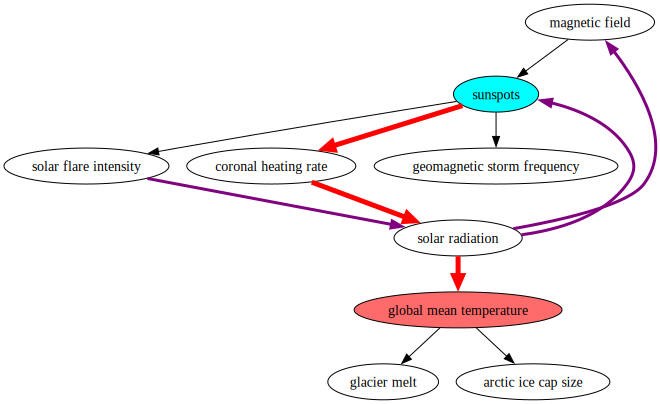

In [ ]:
#render graph to show in notebook
#can be used to render again or render the last execution of automated execution

#also useful for rendering old/selected safed graphs again

graph_to_render = 0    #use if automation was used

if run_automation:
    if examples == own_examples:
        file_prefix = f"recent/automated/own_examples/"
    elif examples == tubing_examples:
        file_prefix = f"recent/automated/tubing_examples/"


    start = examples[graph_to_render][0]
    #filename = f"recent/automated/{start}"
    filename = file_prefix + start_var[:8] + "--" + end_var[:8], output

    filename = last_save

    dic = load(filename + ".txt")

    trees = dic["trees"]
    connections = dic["connection"]
    start = dic["example"][0]
    end = dic["example"][1]
    render(trees, start=start, end=end, highlights=connections)
else:
    filename = last_save #+ "_edit1"
    dic = load(filename + ".txt")

    #trees = [dic["trees"][0],dic["trees"][1]]

    trees = dic["trees"]
    connections = dic["connection"]
    start = dic["example"][0]
    end = dic["example"][1]
    render(trees, start=start, end=end, highlights=connections)#, generate_at = "dev_pdf")

In [13]:
#tubing check
check = True

if check:

    #adjust parametrers
    run_automation = 1
    examples = tubing_examples

    chosen_example =  18     #to use without automation
    run_from = 1          #to use with automation
    run_to =  108           #applied like ls[run_from-1:run_to] 
    nth_element = 1  


    examples = tubing_examples

    example_sublist = examples[run_from-1:run_to] 
    example_sublist = example_sublist[0::nth_element]
    num_runs = len(example_sublist) -1
    run_id = 0

    correct = 0
    wrong = []

    for example in example_sublist:
        start_var = example[0]
        end_var = example[1]

        pair_id = example[2]

        file_prefix = f"recent/automated/tubing_examples/"
        filename = file_prefix + pair_id#start_var[:8] + "--" + end_var[:8]#, output
        dic = load(filename + ".txt")


        trees = dic["trees"]
        connections = dic["connection"]
        start = dic["example"][0]
        end = dic["example"][1]


        tubingG = nx.DiGraph()
        for tree in trees:
            for edge in tree["edges"]:
                tubingG.add_edge(edge[0].lower(), edge[1].lower())
        for c in connections:
            c2 = c["edge"]
            if c2 != []:
                tubingG.add_edge(c2[0].lower(), c2[1].lower())


        for i in tubing:

            if tubing[i]["var1"].replace(","," -") == start and tubing[i]["var2"].replace(","," -") == end:
                #print(start, end, tubing[i]["direction"])
                print(i)
                if tubing[i]["direction"] == "->":
                    if nx.has_path(tubingG, start.lower(), end.lower()):
                        correct += 1
                    else:
                        wrong.append((start, end))
                else:
                    if nx.has_path(tubingG, end.lower(), start.lower()):
                        correct += 1
                    else:
                        wrong.append((start, end))
                break

    print(correct, " / ", num_runs)
    print("wrong: \n", wrong)

# note -> vars sometimes change spelling during execution (e.g. Stock return of Cheung kong -->> Stock return of Cheung Kong)


pair0001
pair0002
pair0003
pair0004
pair0005
pair0006
pair0007
pair0008
pair0009
pair0010
pair0011
pair0012
pair0013
pair0014
pair0015
pair0016
pair0017
pair0018
pair0019
pair0020
pair0021
pair0022
pair0023
pair0024
pair0025
pair0026
pair0027
pair0028
pair0029
pair0030
pair0031
pair0032
pair0033
pair0034
pair0035
pair0036
pair0037
pair0038
pair0039
pair0040
pair0041
pair0042
pair0043
pair0044
pair0045
pair0046
pair0047
pair0048
pair0049
pair0055
pair0056
pair0060
pair0064
pair0065
pair0066
pair0067
pair0068
pair0069
pair0070
pair0071
pair0072
pair0073
pair0074
pair0075
pair0076
pair0077
pair0078
pair0079
pair0080
pair0081
pair0084
pair0085
pair0086
pair0087
pair0088
pair0091
pair0092
pair0093
pair0094
pair0095
pair0096
pair0097
pair0099
pair0100
pair0101
pair0102
pair0104
pair0105
pair0106
pair0107
pair0108
75  /  90
wrong: 
 [('Abalone Age', 'Shell weight'), ('Abalone Age', 'Shucked weight'), ('Age', 'Wage per hour'), ('Age', 'Concentration GAG'), ('duration of eruption', 'time to the

In [14]:
#crab check
check2 = True

if check2:

    #ajust parameters
    run_automation = 1
    examples = crab_examples

    chosen_example =  18     #to use without automation
    run_from = 1          #to use with automation 
    run_to =  80           #applied like ls[run_from-1:run_to] 
    nth_element = 1  



    example_sublist = examples[run_from-1:run_to] 
    example_sublist = example_sublist[0::nth_element]
    num_runs = len(example_sublist)
    run_id = 0

    correct = 0
    wrong = []

    for example in example_sublist:
        start_var = example[0]
        end_var = example[1]

        pair_id = example[2]

        file_prefix = f"recent/automated/crab_examples/"
        filename = file_prefix + pair_id#start_var[:8] + "--" + end_var[:8]#, output

        dic = load(filename + ".txt")


        trees = dic["trees"]
        connections = dic["connection"]
        start = dic["example"][0]
        end = dic["example"][1]

        crabG = nx.DiGraph()
        for tree in trees:
            for edge in tree["edges"]:
                crabG.add_edge(edge[0].lower(), edge[1].lower())
        for c in connections:
            c2 = c["edge"]
            if c2 != []:
                crabG.add_edge(c2[0].lower(), c2[1].lower())


        for i in crab_load:
            if i["event_a"] == example[0] and i["event_b"] == example[1]:
                print(i)

                if i["direction"] == "->":
                    try:
                        if nx.has_path(crabG, start.lower(), end.lower()):
                            correct += 1
                        else:
                            wrong.append(pair_id)
                    except nx.NodeNotFound:
                        print("hmmm")
                else:
                    if nx.has_path(tubingG, end.lower(), start.lower()):
                        correct += 1
                    else:
                        wrong.append(pair_id)

    print(correct, " / ", num_runs)
    print("wrong: \n", wrong)

# note -> vars sometimes change spelling during execution (e.g. Stock return of Cheung kong -->> Stock return of Cheung Kong)

{'pair_id': '0010', 'event_a': 'Anti-incumbent sentiment is the dominant political sentiment in Latin America', 'event_b': "Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide' in two decades", 'direction': '->'}
{'pair_id': '0011', 'event_a': 'Colombia elects Gustavo Petro, a 62-year-old former guerrilla', 'event_b': "Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide' in two decades", 'direction': '->'}
{'pair_id': '0012', 'event_a': 'Many see a window of opportunity for greater regional unity in Latin America', 'event_b': '11 former presidents and foreign ministers from Latin America wrote an open letter to current heads of state, emphasizing the need for regional integration', 'direction': '->'}
{'pair_id': '0013', 'event_a': "Leftist governments come into power across Latin America in 2022, marking the region's second 'pink tide' in two decades", 'event_b': '11 former preside